In [37]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
import itertools

# TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas import Timestamp
from datetime import datetime

#MODELLING
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
# settings
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 변수 지정
df_item_categories = pd.read_csv('item_categories.csv')
df_items = pd.read_csv('items.csv')
df_train = pd.read_csv('sales_train.csv')
df_shops = pd.read_csv('shops.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

In [3]:
df_train.drop_duplicates(inplace=True)

In [4]:
df_train = df_train[(df_train.item_price < 100000)&(df_train.item_price >= 0)]
df_train = df_train[(df_train.item_cnt_day >= 0)&(df_train.item_cnt_day < 1000)]

In [5]:
# =============================================================================
# CLEANING DF_SHOP
# =============================================================================

df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops.loc[df_shops.city=='!Якутск','city']='Якутск'
df_shops['city_id']=LabelEncoder().fit_transform(df_shops['city'])


df_shops['cat_tienda'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[1])
category = []
for cat in df_shops.cat_tienda.unique():
    if len(df_shops[df_shops.cat_tienda == cat]) >= 5:
        category.append(cat)
df_shops.cat_tienda = df_shops.cat_tienda.apply( lambda x: x if (x in category) else "other" )

df_shops['shop_cat']=LabelEncoder().fit_transform(df_shops['cat_tienda'])

df_shops=df_shops[['city','shop_id','city_id','shop_cat']]

In [7]:
df_train['revenue']=df_train['item_price']*df_train['item_cnt_day']

In [8]:
df_train["date"] = pd.to_datetime(df_train["date"], format = "%d.%m.%Y")
df_train.set_index('date').head()

date_block_num  shop_id  item_id  item_price  item_cnt_day  \
date                                                                     
2013-01-02               0       59    22154      999.00           1.0   
2013-01-03               0       25     2552      899.00           1.0   
2013-01-06               0       25     2554     1709.05           1.0   
2013-01-15               0       25     2555     1099.00           1.0   
2013-01-10               0       25     2564      349.00           1.0   

            revenue  
date                 
2013-01-02   999.00  
2013-01-03   899.00  
2013-01-06  1709.05  
2013-01-15  1099.00  
2013-01-10   349.00

In [10]:
full_df=pd.merge(df_train,df_shops,on=['shop_id'],how='left')
full_df=pd.merge(full_df,df_items,on=['item_id'],how='left')
full_df=pd.merge(full_df,df_item_categories,on=['item_category_id'],how='left')
full_df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-06               0       25     2554     1709.05           1.0   
3 2013-01-15               0       25     2555     1099.00           1.0   
4 2013-01-10               0       25     2564      349.00           1.0   

   revenue       city  city_id  shop_cat  \
0   999.00  Ярославль       30         4   
1   899.00     Москва       13         2   
2  1709.05     Москва       13         2   
3  1099.00     Москва       13         2   
4   349.00     Москва       13         2   

                                           item_name  item_category_id  \
0                                  ЯВЛЕНИЕ 2012 (BD)                37   
1           DEEP PURPLE  The House Of Blue Light  LP                58   
2           DEEP PURPLE  Who Do You Think We Are  LP                58   
3            DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   
4  DEEP PURPLE Perihelion: Live In Concert DVD (К...                59   

                    item_category_name  
0                       Кино - Blu-Ray  
1                       Музыка - Винил  
2                       Музыка - Винил  
3  Музыка - CD фирменного производства  
4           Музыка - Музыкальное видео

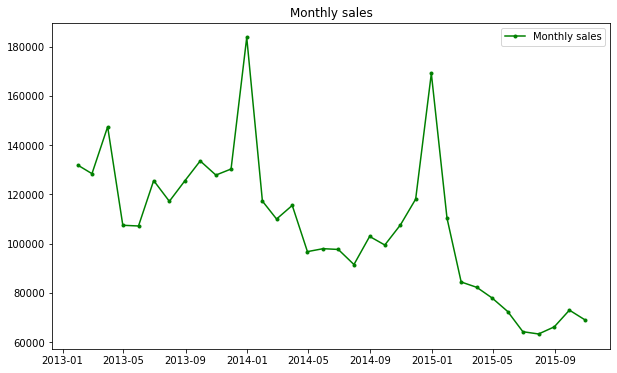

In [11]:
ts_M = full_df[["date", "item_cnt_day"]].set_index("date").resample("M").sum()

plt.figure(figsize = (10, 6))
plt.plot(ts_M, color = "Green", label = "Monthly sales",marker='.')
plt.title("Monthly sales")
plt.legend();

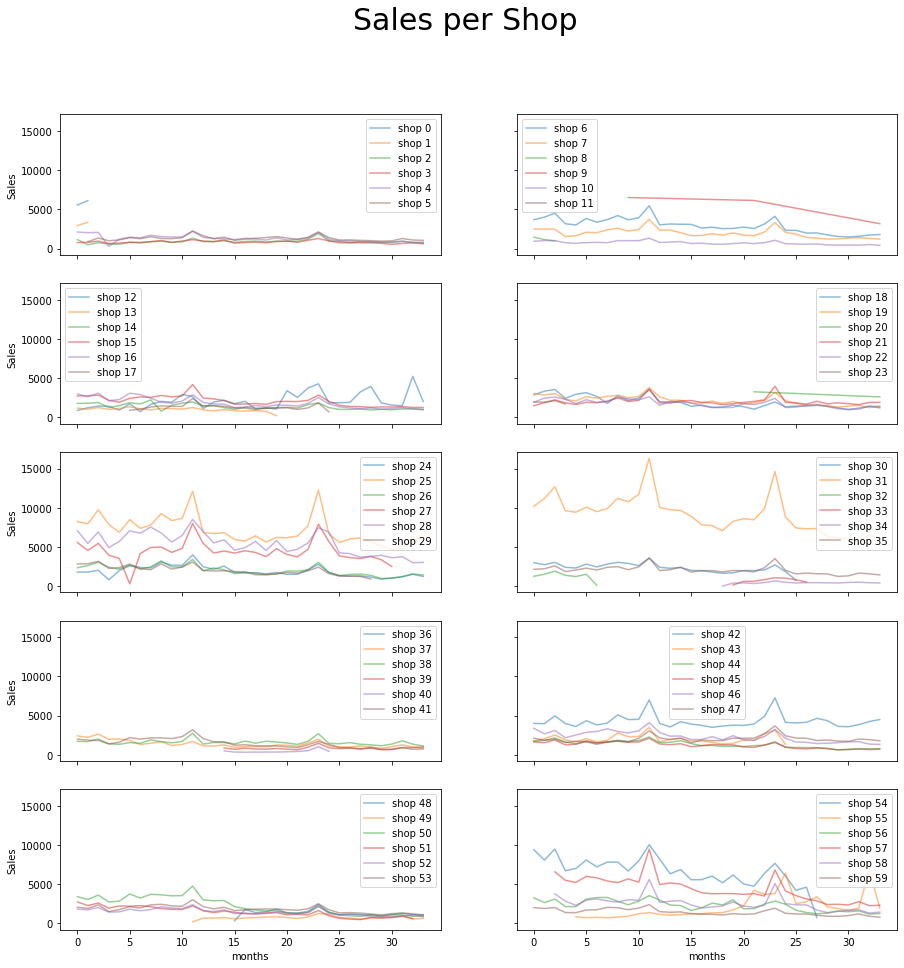

In [12]:
fig,ax = plt.subplots(nrows=5, ncols=2,sharex=True, sharey=True,figsize=(15,15))
fig.suptitle('Sales per Shop', fontsize=30)
ts_shop = full_df.groupby(['shop_id','date_block_num'])['item_cnt_day'].sum().reset_index()
shop_count=0
for i in range(5):
    for j in range(2):
        for z in range(6):
            ax[i,j].plot(ts_shop[ts_shop['shop_id']==shop_count]['date_block_num'],ts_shop[ts_shop['shop_id']==shop_count]['item_cnt_day'],alpha=.5,label='shop '+str(shop_count))
            shop_count += 1
            ax[i,j].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='months', ylabel='Sales')
    ax.label_outer()

[Text(0.5, 0, 'item category'), Text(0, 0.5, 'Sales')]

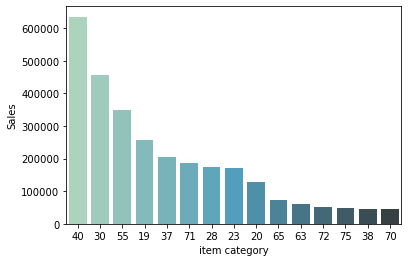

In [13]:
items_x_cat=full_df.groupby('item_category_id').agg({'item_cnt_day':'sum'})
items_x_cat.reset_index(inplace=True)
items_x_cat=items_x_cat.sort_values('item_cnt_day',ascending=False)
items_x_cat_top=items_x_cat[0:15] 
items_x_cat_top['item_category_id']=items_x_cat_top['item_category_id'].astype(object)
items_x_cat_top=items_x_cat_top.reset_index(drop=True)
barplot=sns.barplot(y='item_cnt_day',x='item_category_id',palette='GnBu_d',data=items_x_cat_top,order=items_x_cat_top.sort_values('item_cnt_day',ascending=False).item_category_id)
barplot.set(xlabel="item category", ylabel = "Sales")

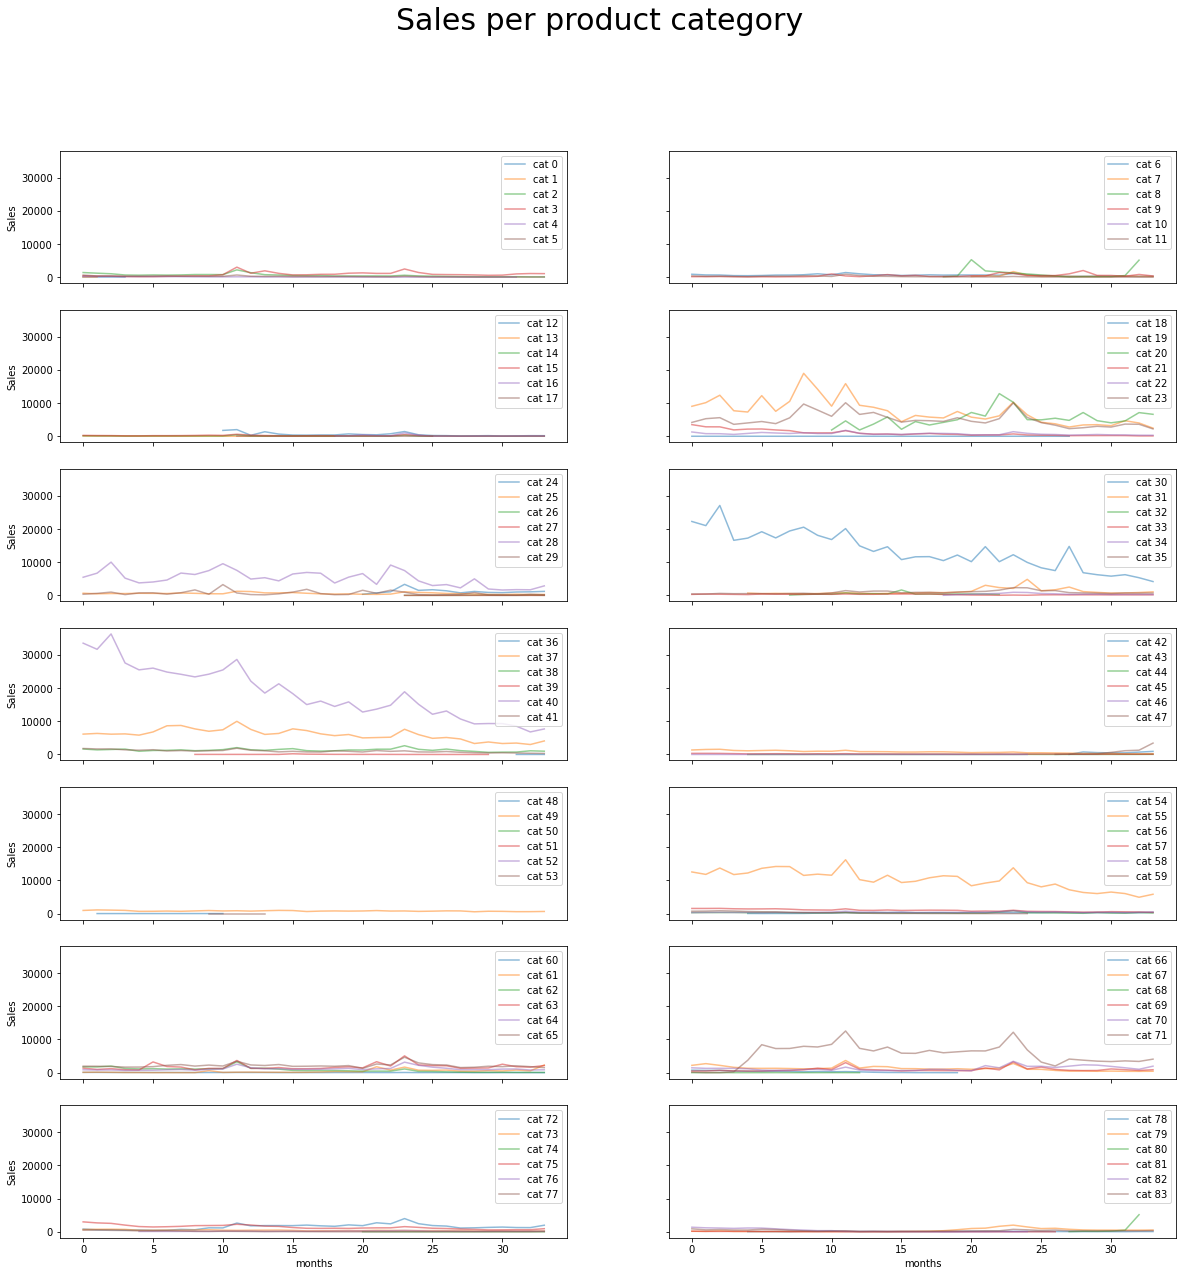

In [14]:
fig,ax = plt.subplots(nrows=7, ncols=2,sharex=True, sharey=True,figsize=(20,20))
fig.suptitle('Sales per product category', fontsize=30)
ts_cat = full_df.groupby(['item_category_id','date_block_num'])['item_cnt_day'].sum().reset_index()
cat_count=0
for i in range(7):
    for j in range(2):
        for z in range(6):
            ax[i,j].plot(ts_cat[ts_cat['item_category_id']==cat_count]['date_block_num'],ts_cat[ts_cat['item_category_id']==cat_count]['item_cnt_day'],alpha=.5,label='cat '+str(cat_count))
            cat_count += 1
            ax[i,j].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='months', ylabel='Sales')
    ax.label_outer()

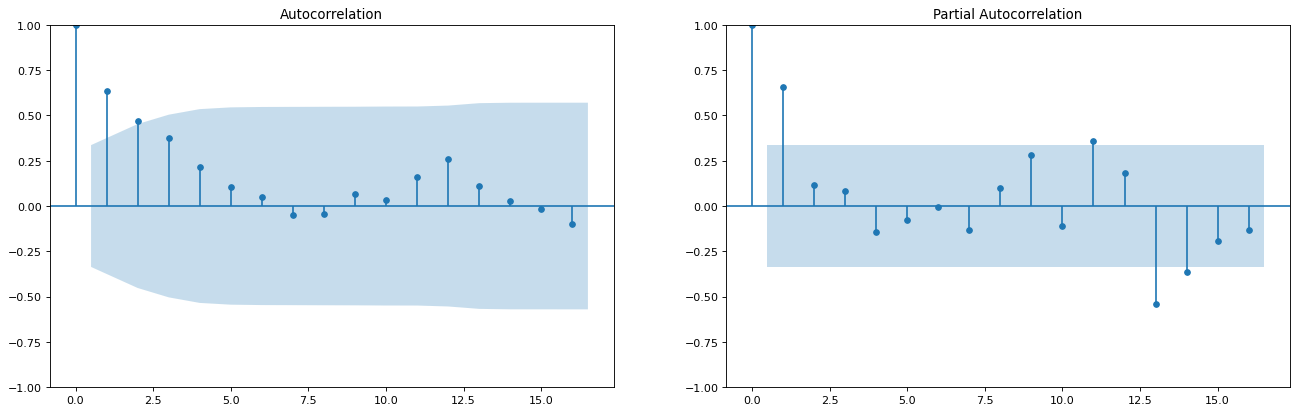

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,6), dpi = 80)
plot_acf(ts_M, ax = ax1, lags = 16)
plot_pacf(ts_M, ax = ax2, lags = 16);

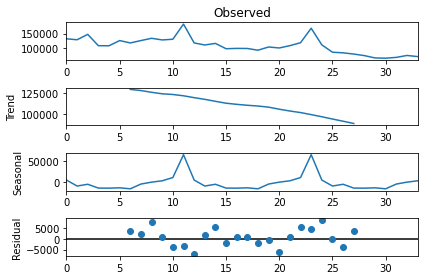

In [21]:
res = seasonal_decompose(ts_M.values, period=12, model='additive')
fig = res.plot()

In [22]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic:','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [23]:
test_stationarity(ts_M)

Results of Dickey-Fuller Test:
ADF Statistic:                 -2.372252
p-value                         0.149722
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [24]:
def normalize(ts):
    avg,dev=ts.mean(), ts.std()
    ts=(ts-avg)/dev
    return ts

def remove_seasonality(ts):
    ts= ts-ts.shift(12)
    ts=ts.dropna()
    return ts

def remove_trend(ts):
    ts= ts.diff(1).dropna()
    return ts

Text(0, 0.5, 'Total de ventas')

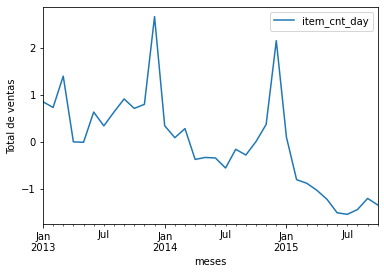

In [25]:
# Normalize TS
ts_norm=normalize(ts_M)
ts_norm.plot()
plt.xlabel('meses')
plt.ylabel('Total de ventas')

Results of Dickey-Fuller Test:
ADF Statistic:                 -3.181500
p-value                         0.021081
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


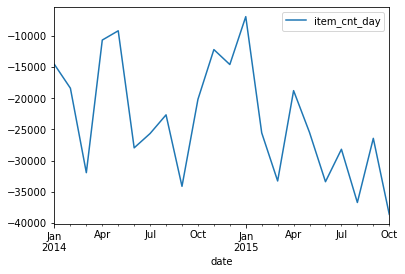

In [26]:
# Remove seasonality
ts_est=remove_seasonality(ts_M)
ts_est.plot()
test_stationarity(ts_est)

Results of Dickey-Fuller Test:
ADF Statistic:                -1.331376e+01
p-value                        6.666090e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


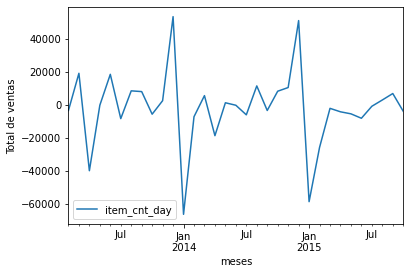

In [27]:
#Remove trend
ts_trend=remove_trend(ts_M)
ts_trend.plot()
plt.xlabel('meses')
plt.ylabel('Total de ventas')
test_stationarity(ts_trend)

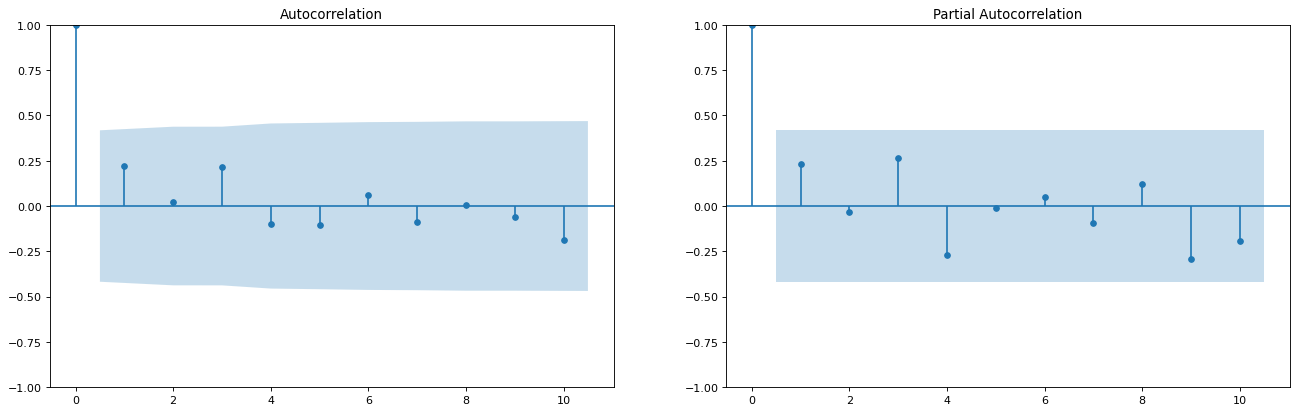

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6), dpi = 80)
plot_acf(ts_est, ax = ax1, lags = 10)
plot_pacf(ts_est, ax = ax2, lags = 10);

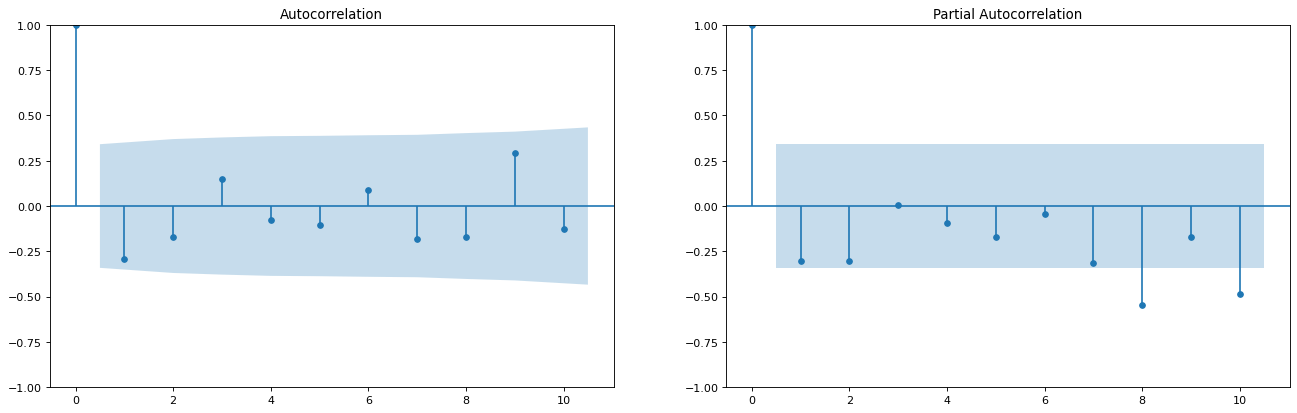

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6), dpi = 80)
plot_acf(ts_trend, ax = ax1, lags = 10)
plot_pacf(ts_trend, ax = ax2, lags = 10);

In [31]:
def create_pred_list(X,Y):
    lista_shops=X['shop_id'].tolist()
    preds=[]
    for shop in range(0,len(Y)):
        preds.append(np.array([lista_shops[shop],Y[shop]]))
    return preds

def submission_df(df_forc_items):
    df_final=pd.merge(df_sub,df_forc_items,how='left',on=['ID'])
    df_final.fillna(0,inplace=True)
    return df_final

def evaluation(df_pred):
    df_eval=pd.merge(df_valid,df_pred, on=['ID'],how='inner')
    error = sqrt(mean_squared_error(df_eval['obs'].values, df_eval['pred'].values))
    return error

In [32]:
def middleout_forecasting(predictions,months_weights): 
    month=33-months_weights
    df_forecast=pd.DataFrame(predictions,columns=['shop_id','forecast_shop'])
    
    #we calculate the number of sales per item in each store of the las "month" months
    sales_gb_item=df_train[df_train['date_block_num']>month].groupby(['shop_id','item_id'])["item_cnt_day"].sum()
    sales_gb_item=pd.DataFrame(sales_gb_item)
    sales_gb_item.reset_index(inplace=True)
    sales_gb_item.rename(columns={'item_cnt_day':'item_sales'},inplace=True)
    
    #we calculate the number of sales store of the las "month" months
    sales_gb_shop=df_train[df_train['date_block_num']>month].groupby(['shop_id'])["item_cnt_day"].sum()
    sales_gb_shop=pd.DataFrame(sales_gb_shop)
    sales_gb_shop.reset_index(inplace=True)
    sales_gb_shop.rename(columns={'item_cnt_day':'shop_sales'},inplace=True)
    
    #we calculate the proportion of the sales for each item in every shop in the last "month" months
    sales_gb_full=pd.merge(sales_gb_item,sales_gb_shop,how='left',on=['shop_id'])
    sales_gb_full=pd.merge(sales_gb_full,df_test,how='left',on=['shop_id','item_id'])
    sales_gb_full['weights']=sales_gb_full['item_sales']/sales_gb_full['shop_sales']
    sales_gb_full.drop(['item_sales','shop_sales'],axis=1,inplace=True)
    
    #we calculate the forecast for each item in every store
    df_calc=pd.merge(sales_gb_full,df_forecast,how='left',on=['shop_id'])
    df_calc['item_cnt_month']=(df_calc['weights']*df_calc['forecast_shop']).clip(0,20) #clip the result to submit
    df_calc.drop(['shop_id','item_id','weights','forecast_shop'],axis=1,inplace=True)
    
    return df_calc

In [33]:
#df validation, month 33
df_valid=full_df[full_df['date_block_num']==33].groupby(['shop_id','item_id'])["item_cnt_day"].sum().clip(0,20).to_frame()
df_valid.reset_index(inplace=True)

df_valid=pd.merge(df_valid,df_test, on=['shop_id','item_id'],how='left').sort_values('ID')
df_valid.drop(['item_id','shop_id'],axis=1,inplace=True)
df_valid.rename(columns={'item_cnt_day':'obs'},inplace=True)
df_valid=df_valid[['ID','obs']]

In [34]:
ts_arima=remove_seasonality(ts_M)

In [38]:
p = range(0,4)
d = range(1,2)
q = range(0,4)
pdq = list(itertools.product(p,d,q))

aic=[]
for i in pdq:
    model = sm.tsa.arima.ARIMA(ts_arima.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC: 452.5
ARIMA: (0, 1, 1) >> AIC: 449.78
ARIMA: (0, 1, 2) >> AIC: 451.23
ARIMA: (0, 1, 3) >> AIC: 452.85
ARIMA: (1, 1, 0) >> AIC: 452.42
ARIMA: (1, 1, 1) >> AIC: 451.42
ARIMA: (1, 1, 2) >> AIC: 452.35
ARIMA: (1, 1, 3) >> AIC: 454.35
ARIMA: (2, 1, 0) >> AIC: 452.23
ARIMA: (2, 1, 1) >> AIC: 454.19
ARIMA: (2, 1, 2) >> AIC: 454.35
ARIMA: (2, 1, 3) >> AIC: 453.76
ARIMA: (3, 1, 0) >> AIC: 454.68
ARIMA: (3, 1, 1) >> AIC: 455.45
ARIMA: (3, 1, 2) >> AIC: 456.35
ARIMA: (3, 1, 3) >> AIC: 454.83


In [39]:
optimal = [(pdq[i],j) for i,j in enumerate(aic) if j == min(aic)]
optimal

[((0, 1, 1), 449.78)]

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                   22
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -222.891
Date:                Wed, 13 Jul 2022   AIC                            449.782
Time:                        13:39:06   BIC                            451.871
Sample:                    01-31-2014   HQIC                           450.235
                         - 10-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6431      0.233     -2.765      0.006      -1.099      -0.187
sigma2      9.721e+07   2.13e-10   4.57e+17      0.000    9.72e+07    9.72e+07
Ljung-Box (L1) (Q):                   0.00   Jarque-

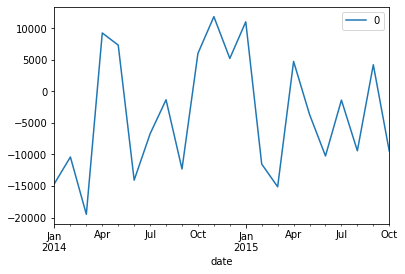

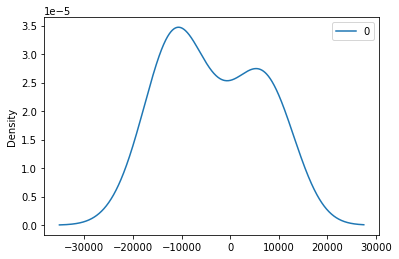

In [40]:
model = sm.tsa.arima.ARIMA(ts_arima, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [41]:
# NIVEL DE TIENDA
ts_shop=df_train.groupby(["date_block_num",'shop_id'])["item_cnt_day"].sum()
ts_shop=ts_shop.unstack(level=1)
ts_shop=ts_shop.fillna(0)

In [42]:
closed_shops=(ts_shop[33:]==0).all()
closed_shops=np.array(closed_shops.index[closed_shops==True])

In [43]:
def train_evaluation_arima(ts,i):
    predictions = list()
    
    X=ts[i].values
    train, test = X[0:33], X[33:]
    history = [x for x in train]
    print('-----------------------shop %f--------------------------' % i)
    if (i in closed_shops or sum(history)==0):
        for t in range(len(test)):
            	predictions.append(0)
    else:
        for t in range(len(test)):
            model = sm.tsa.arima.ARIMA(history, order=(0,1,1))
            model_fit = model.fit()
            output = model_fit.predict(1, len(history)+1, typ='levels')
            yhat = output[-1]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            
            print('predicted=%f, expected=%f' % (yhat, obs))
            error = sqrt(mean_squared_error(test, predictions))
            print('Test MSE: %.3f' % error)
            
            plt.plot(history,label='obs')
            plt.plot(output, label='pred',ls='--')
            plt.xticks(range(0,len(history)+1))
            plt.legend()
            plt.title('shop '+str(i))
            plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

-----------------------shop 0.000000--------------------------
-----------------------shop 1.000000--------------------------
-----------------------shop 2.000000--------------------------
predicted=886.525089, expected=727.000000
Test MSE: 159.525


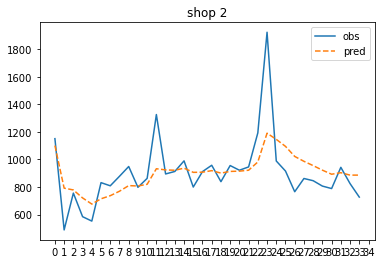

-----------------------shop 3.000000--------------------------
predicted=698.051033, expected=616.000000
Test MSE: 82.051


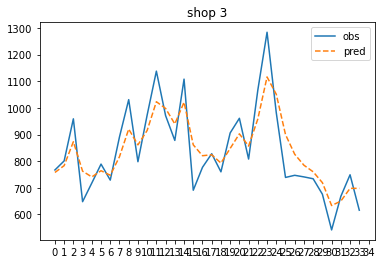

-----------------------shop 4.000000--------------------------
predicted=908.541040, expected=831.000000
Test MSE: 77.541


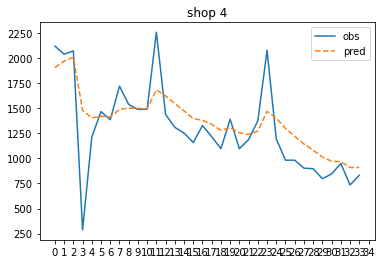

-----------------------shop 5.000000--------------------------
predicted=1129.106588, expected=1054.000000
Test MSE: 75.107


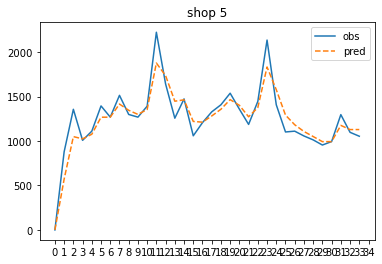

-----------------------shop 6.000000--------------------------
predicted=1662.558663, expected=1803.000000
Test MSE: 140.441


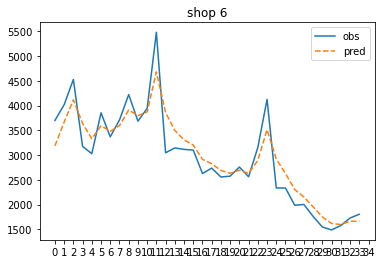

-----------------------shop 7.000000--------------------------
predicted=1322.035547, expected=1216.000000
Test MSE: 106.036


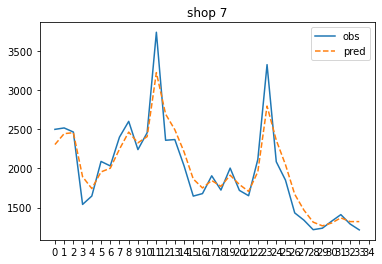

-----------------------shop 8.000000--------------------------
-----------------------shop 9.000000--------------------------
predicted=376.362063, expected=3188.000000
Test MSE: 2811.638


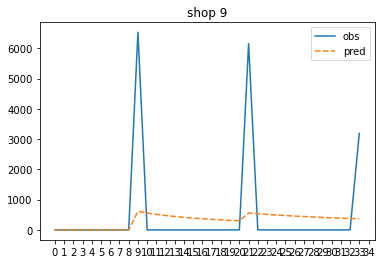

-----------------------shop 10.000000--------------------------
predicted=482.455656, expected=428.000000
Test MSE: 54.456


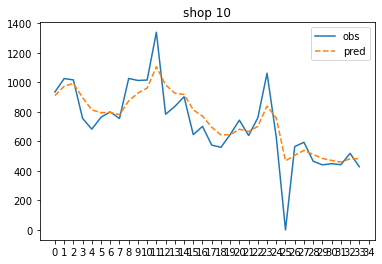

-----------------------shop 11.000000--------------------------
-----------------------shop 12.000000--------------------------
predicted=2836.875253, expected=2016.000000
Test MSE: 820.875


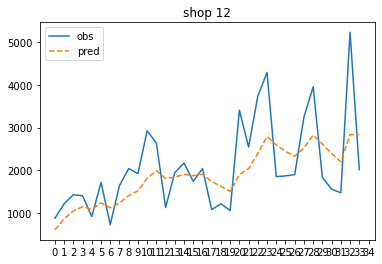

-----------------------shop 13.000000--------------------------
-----------------------shop 14.000000--------------------------
predicted=1070.113542, expected=1007.000000
Test MSE: 63.114


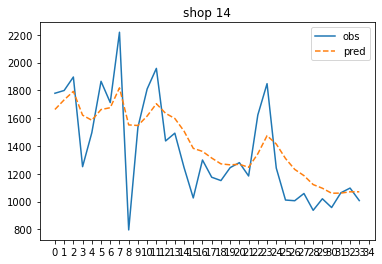

-----------------------shop 15.000000--------------------------
predicted=1296.120754, expected=1248.000000
Test MSE: 48.121


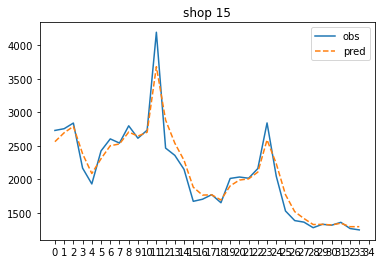

-----------------------shop 16.000000--------------------------
predicted=1118.041400, expected=966.000000
Test MSE: 152.041


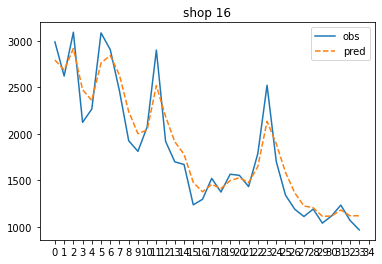

-----------------------shop 17.000000--------------------------
-----------------------shop 18.000000--------------------------
predicted=1285.348727, expected=1212.000000
Test MSE: 73.349


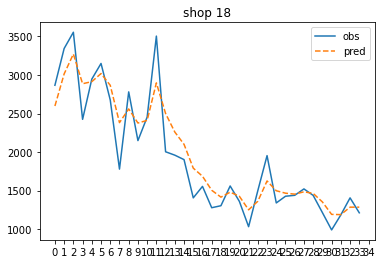

-----------------------shop 19.000000--------------------------
predicted=1342.357842, expected=1453.000000
Test MSE: 110.642


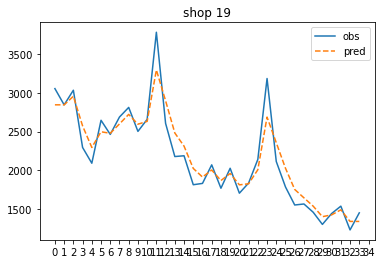

-----------------------shop 20.000000--------------------------
predicted=98.120911, expected=2611.000000
Test MSE: 2512.879


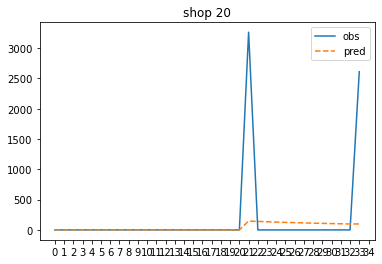

-----------------------shop 21.000000--------------------------
predicted=2010.909265, expected=1913.000000
Test MSE: 97.909


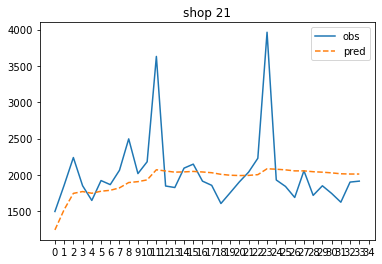

-----------------------shop 22.000000--------------------------
predicted=1258.005312, expected=1338.000000
Test MSE: 79.995


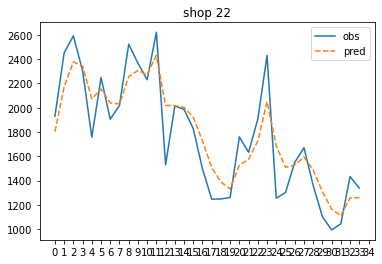

-----------------------shop 23.000000--------------------------
-----------------------shop 24.000000--------------------------
predicted=1329.588444, expected=1228.000000
Test MSE: 101.588


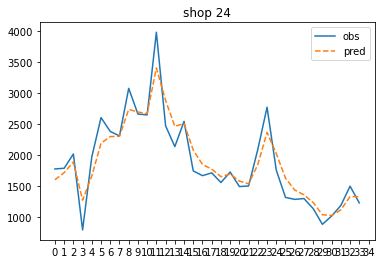

-----------------------shop 25.000000--------------------------
predicted=5445.117249, expected=6261.000000
Test MSE: 815.883


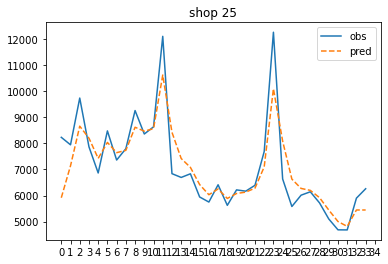

-----------------------shop 26.000000--------------------------
predicted=1342.804287, expected=1412.000000
Test MSE: 69.196


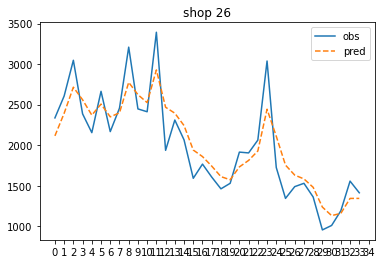

-----------------------shop 27.000000--------------------------
-----------------------shop 28.000000--------------------------
predicted=3309.553470, expected=3021.000000
Test MSE: 288.553


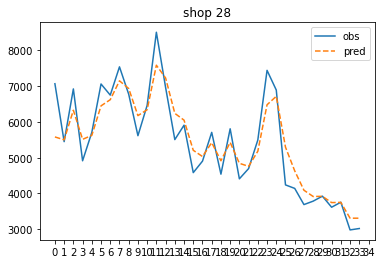

-----------------------shop 29.000000--------------------------
-----------------------shop 30.000000--------------------------
-----------------------shop 31.000000--------------------------
predicted=6373.892037, expected=6119.000000
Test MSE: 254.892


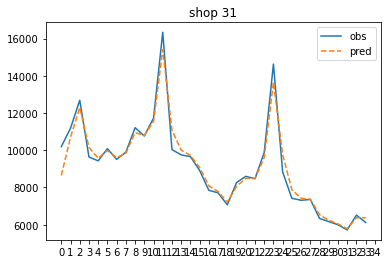

-----------------------shop 32.000000--------------------------
-----------------------shop 33.000000--------------------------
-----------------------shop 34.000000--------------------------
predicted=424.331979, expected=385.000000
Test MSE: 39.332


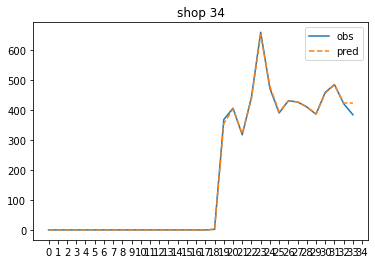

-----------------------shop 35.000000--------------------------
predicted=1549.314580, expected=1421.000000
Test MSE: 128.315


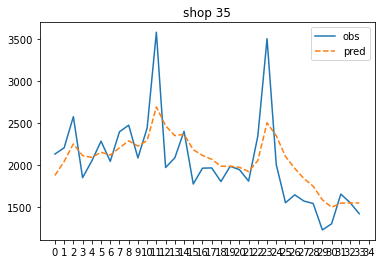

-----------------------shop 36.000000--------------------------
-----------------------shop 37.000000--------------------------
predicted=1049.741359, expected=833.000000
Test MSE: 216.741


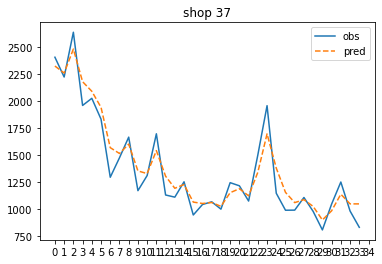

-----------------------shop 38.000000--------------------------
predicted=1598.894839, expected=1114.000000
Test MSE: 484.895


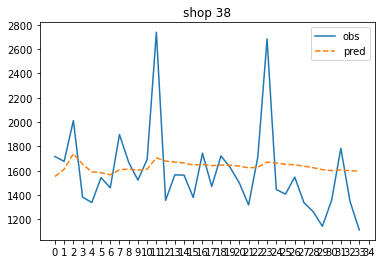

-----------------------shop 39.000000--------------------------
predicted=892.325190, expected=998.000000
Test MSE: 105.675


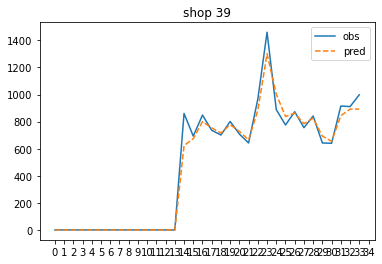

-----------------------shop 40.000000--------------------------
-----------------------shop 41.000000--------------------------
predicted=719.931774, expected=743.000000
Test MSE: 23.068


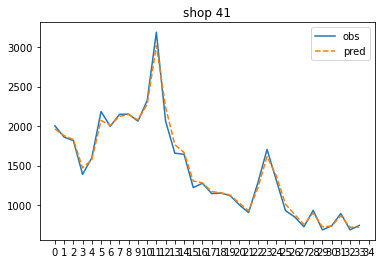

-----------------------shop 42.000000--------------------------
predicted=4209.288301, expected=4498.000000
Test MSE: 288.712


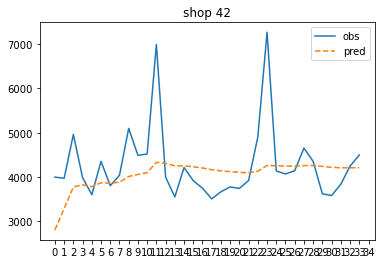

-----------------------shop 43.000000--------------------------
-----------------------shop 44.000000--------------------------
predicted=751.154978, expected=780.000000
Test MSE: 28.845


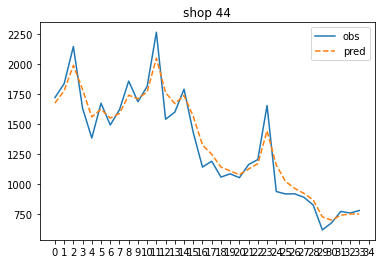

-----------------------shop 45.000000--------------------------
predicted=686.943117, expected=702.000000
Test MSE: 15.057


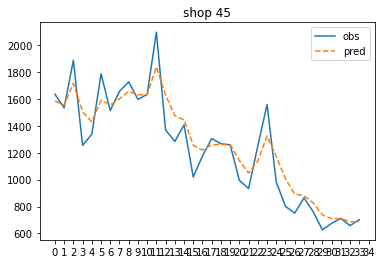

-----------------------shop 46.000000--------------------------
predicted=1492.676453, expected=1322.000000
Test MSE: 170.676


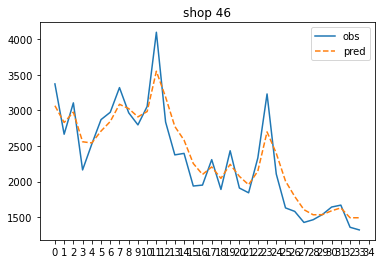

-----------------------shop 47.000000--------------------------
predicted=1924.172502, expected=1785.000000
Test MSE: 139.173


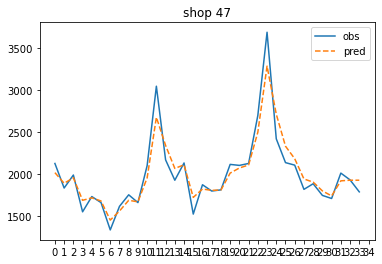

-----------------------shop 48.000000--------------------------
predicted=1141.626740, expected=1119.000000
Test MSE: 22.627


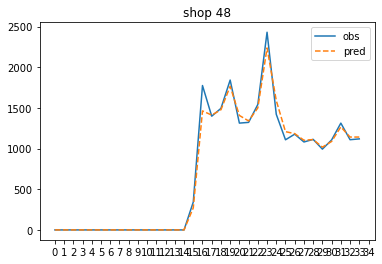

-----------------------shop 49.000000--------------------------
predicted=450.120058, expected=649.000000
Test MSE: 198.880


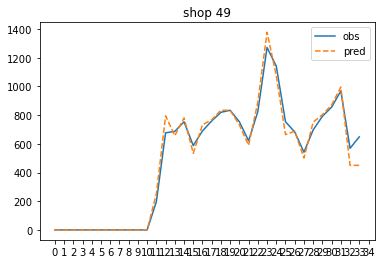

-----------------------shop 50.000000--------------------------
predicted=966.814379, expected=950.000000
Test MSE: 16.814


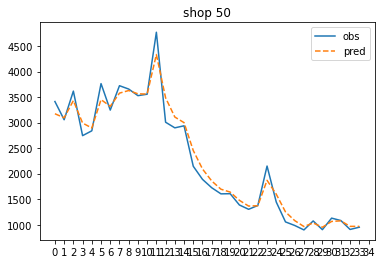

-----------------------shop 51.000000--------------------------
-----------------------shop 52.000000--------------------------
predicted=998.115779, expected=852.000000
Test MSE: 146.116


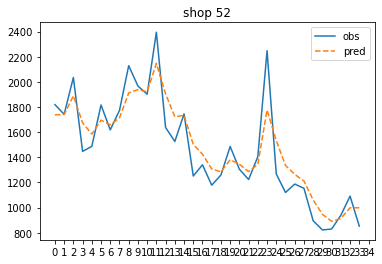

-----------------------shop 53.000000--------------------------
predicted=1253.124808, expected=1065.000000
Test MSE: 188.125


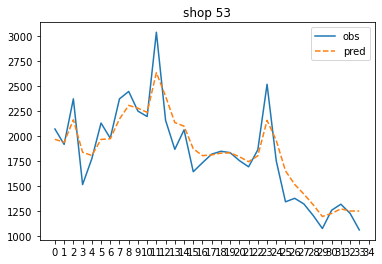

-----------------------shop 54.000000--------------------------
-----------------------shop 55.000000--------------------------
predicted=4787.769421, expected=1972.000000
Test MSE: 2815.769


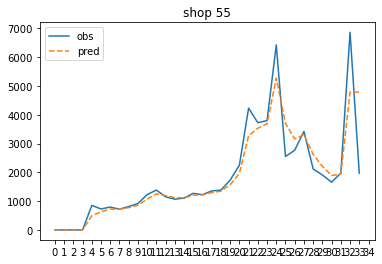

-----------------------shop 56.000000--------------------------
predicted=1343.063719, expected=1267.000000
Test MSE: 76.064


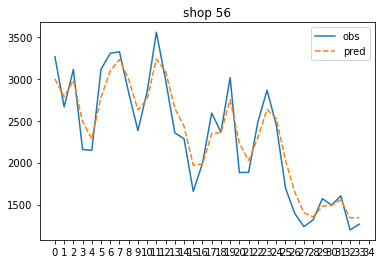

-----------------------shop 57.000000--------------------------
predicted=2416.074166, expected=2319.000000
Test MSE: 97.074


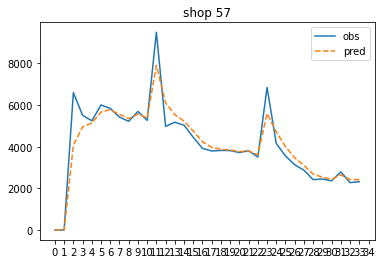

-----------------------shop 58.000000--------------------------
predicted=1533.335043, expected=1448.000000
Test MSE: 85.335


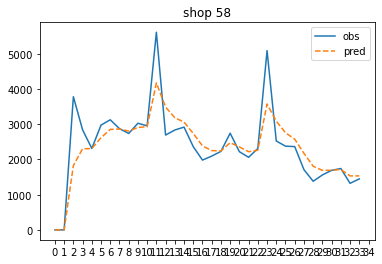

-----------------------shop 59.000000--------------------------
predicted=985.234999, expected=792.000000
Test MSE: 193.235


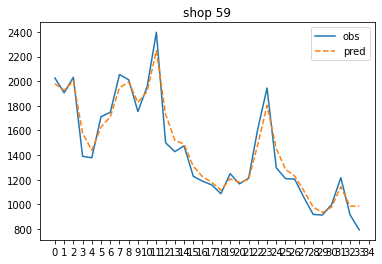

In [44]:
lista_pred_arima=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima.append(train_evaluation_arima(ts_shop,i))

In [49]:
df_pred_arima=middleout_forecasting(lista_pred_arima,3)
df_pred_arima=submission_df(df_pred_arima)
df_pred_arima.rename(columns={'item_cnt_month_y':'pred'},inplace=True)

In [50]:
error_arima = evaluation(df_pred_arima)
print('Test MSE: %.3f' % error_arima)

Test MSE: 1.617


In [51]:
def forecast_arima_shops(ts,i):
    predictions = list()
    train=ts[i].values
    
    if (i in closed_shops or sum(train)==0):
        predictions.append(0)
    else:
        model = sm.tsa.arima.ARIMA(train, order=(0,1,1))
        model_fit = model.fit()
        output = model_fit.predict(1, len(train)+1, typ='levels')
        yhat = output[-1]
        predictions.append(yhat)

        plt.plot(train,label='obs')
        plt.plot(output, label='pred',ls='--')
        plt.xticks(range(0,len(train)+1))
        plt.legend()
        plt.title('shop '+str(i))
        plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

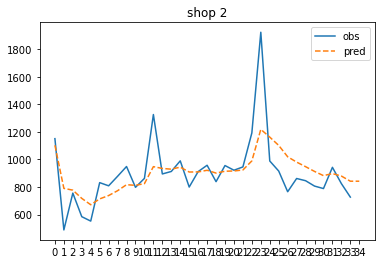

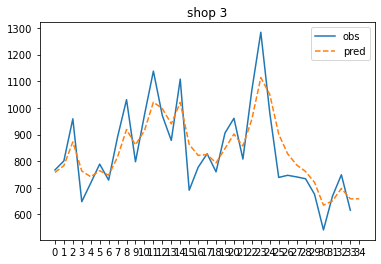

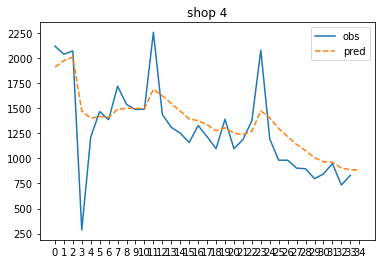

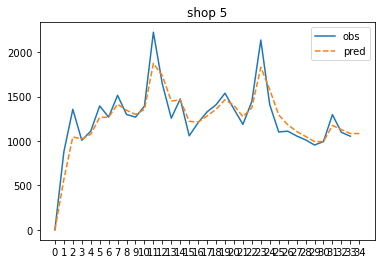

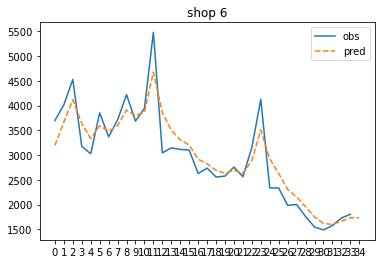

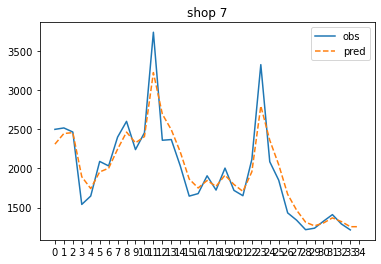

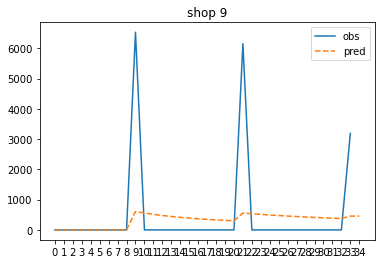

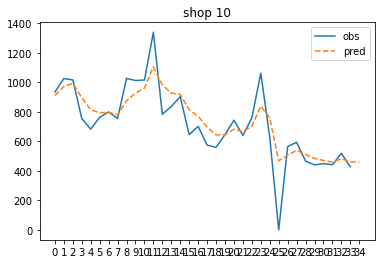

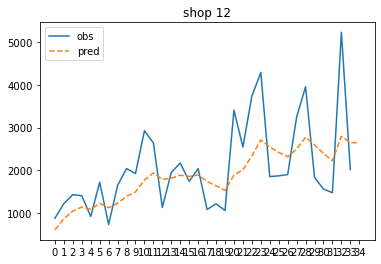

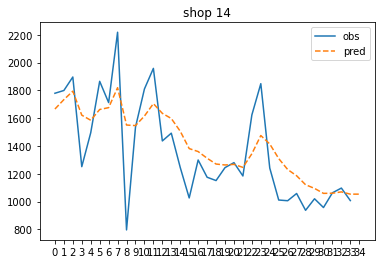

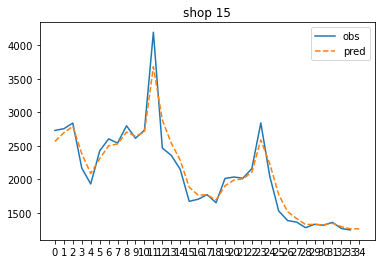

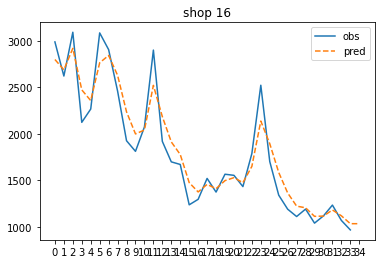

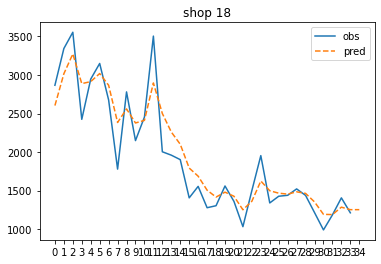

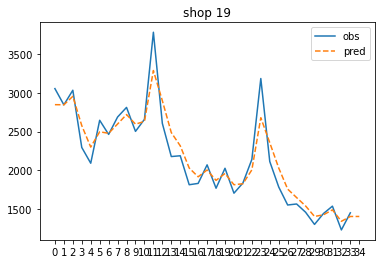

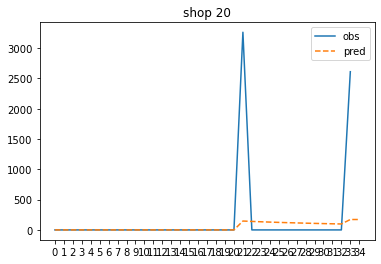

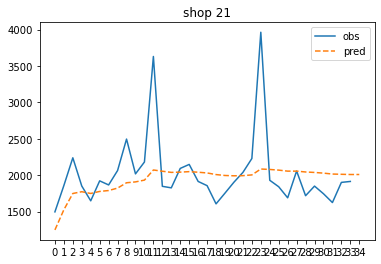

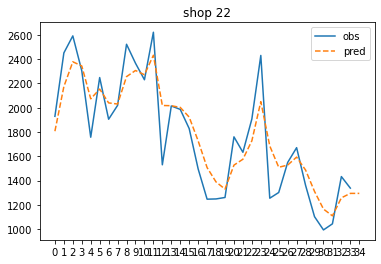

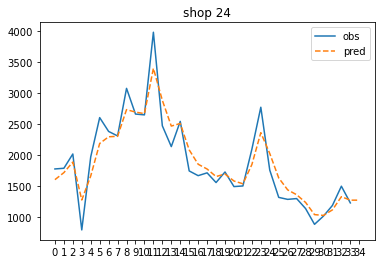

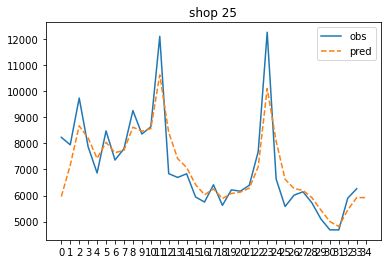

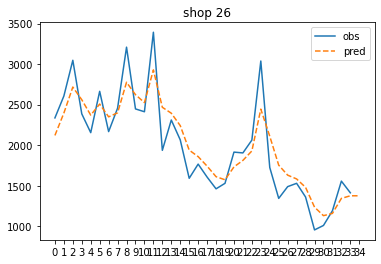

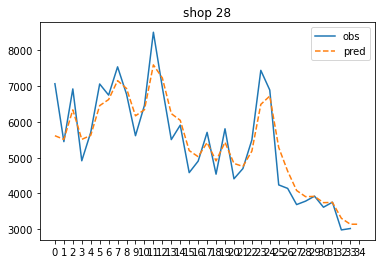

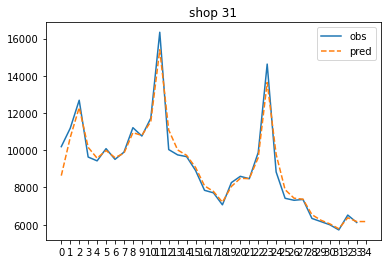

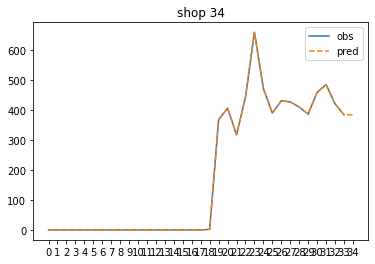

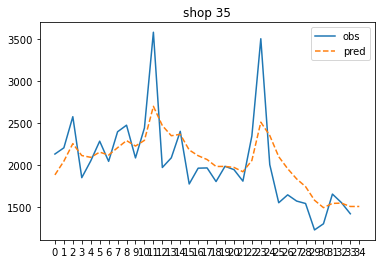

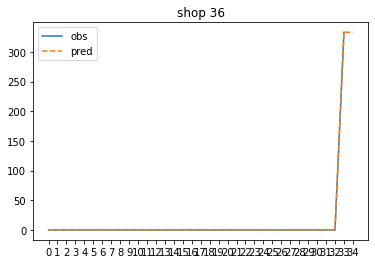

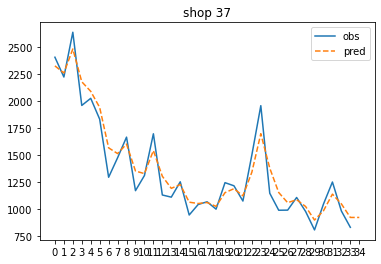

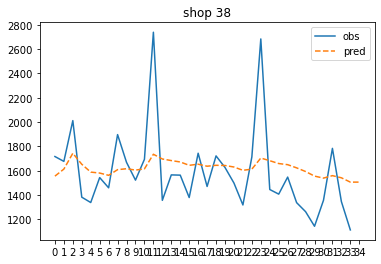

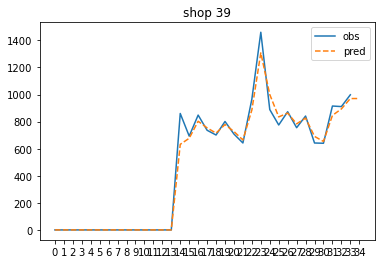

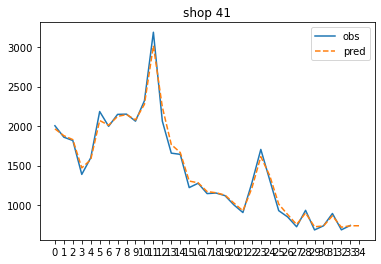

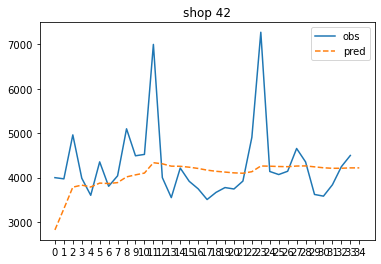

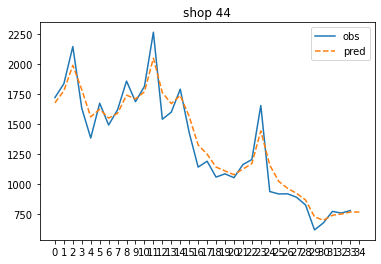

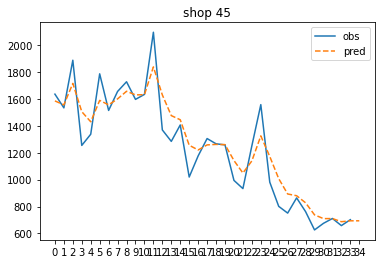

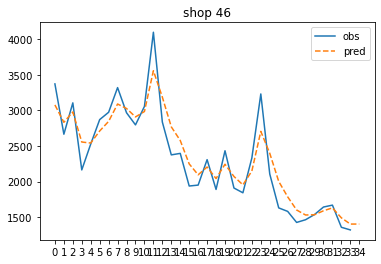

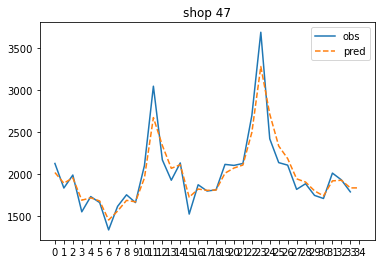

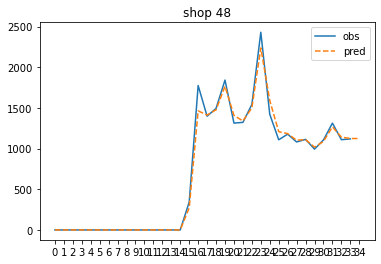

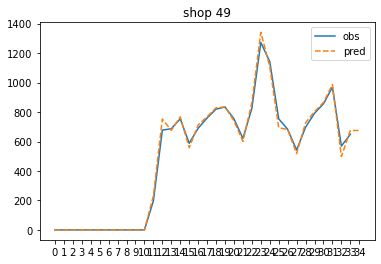

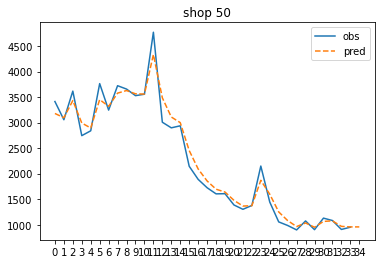

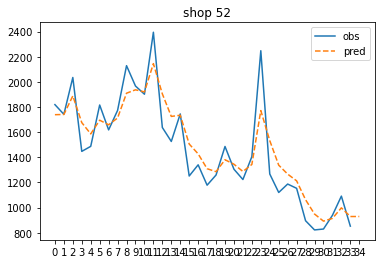

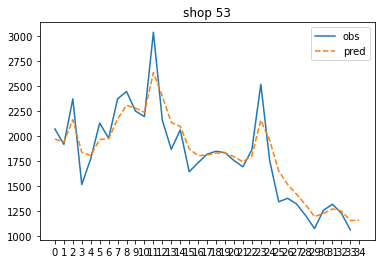

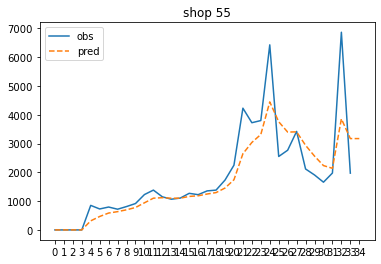

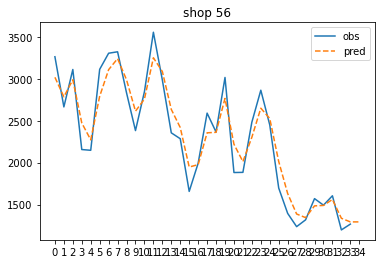

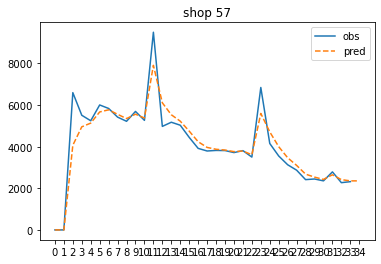

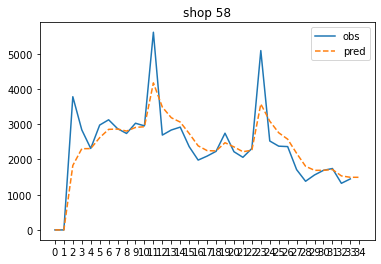

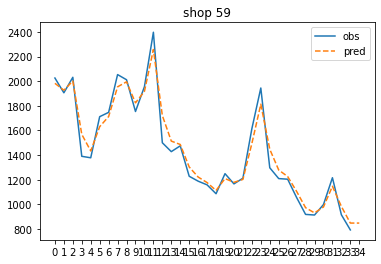

In [52]:
lista_pred_arima_test=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima_test.append(forecast_arima_shops(ts_shop,i))

In [53]:
df_forecast_items=middleout_forecasting(lista_pred_arima_test,3)

In [33]:
# df_final=submission_df(df_forecast_items)
# df_final.to_csv('submission_arima_1.csv', index=False)

## Sarima

In [54]:
ts_arima=remove_seasonality(ts_M)

In [55]:
auto_arima_model = auto_arima(ts_arima, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12, seasonal=True,
                             d=1, D=1,
                             max_P=3, max_Q=3,   
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=199.790, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=198.047, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=199.132, Time=0.04 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=200.697, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=197.361, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=198.999, Time=0.03 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=200.727, Time=0.06 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=202.529, Time=0.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=199.361, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=202.727, Time=0.06 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=204.529, Time=0.13 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=201.361, Time=0.08 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=204.727, Time=0.11 sec
 ARIMA(0,1,1)(0,1,

In [56]:
# Best model:  ARIMA(0,1,3)(0,1,1)[12]

                                      SARIMAX Results                                       
Dep. Variable:                         item_cnt_day   No. Observations:                   22
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                 -87.876
Date:                              Wed, 13 Jul 2022   AIC                            185.753
Time:                                      13:56:54   BIC                            186.739
Sample:                                  01-31-2014   HQIC                           183.625
                                       - 10-31-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3436      0.772     -1.740      0.082      -2.857       0.170
ma.L2          0.93

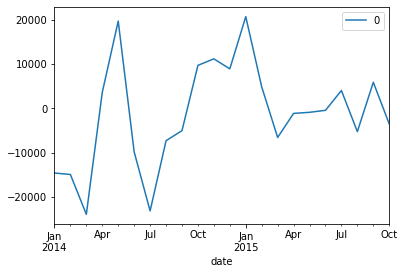

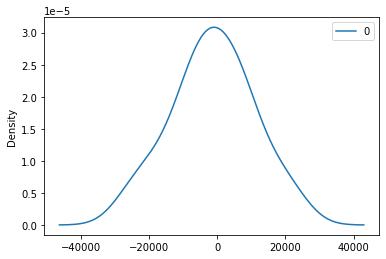

In [57]:
model = SARIMAX(ts_arima, order=(0,1,3), seasonal_order=(0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [58]:
# NIVEL DE TIENDA
ts_shop=df_train.groupby(["date_block_num",'shop_id'])["item_cnt_day"].sum()
ts_shop=ts_shop.unstack(level=1)
ts_shop=ts_shop.fillna(0)

In [59]:
closed_shops=(ts_shop[33:]==0).all()
closed_shops=np.array(closed_shops.index[closed_shops==True])

In [60]:
def train_evaluation_arima(ts,i):
    predictions = list()
    
    X=ts[i].values
    train, test = X[0:33], X[33:]
    history = [x for x in train]
    print('-----------------------shop %f--------------------------' % i)
    if (i in closed_shops or sum(history)==0):
        for t in range(len(test)):
            	predictions.append(0)
    else:
        for t in range(len(test)):
            model = SARIMAX(history, order=(0,1,3), seasonal_order=(0,1,1,12))
            model_fit = model.fit()
            output = model_fit.predict(1, len(history)+1, typ='levels')
            yhat = output[-1]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            
            print('predicted=%f, expected=%f' % (yhat, obs))
            error = sqrt(mean_squared_error(test, predictions))
            print('Test MSE: %.3f' % error)
            
            plt.plot(history,label='obs')
            plt.plot(output, label='pred',ls='--')
            plt.xticks(range(0,len(history)+1))
            plt.legend()
            plt.title('shop '+str(i))
            plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

-----------------------shop 0.000000--------------------------
-----------------------shop 1.000000--------------------------
-----------------------shop 2.000000--------------------------
predicted=1093.847508, expected=727.000000
Test MSE: 366.848


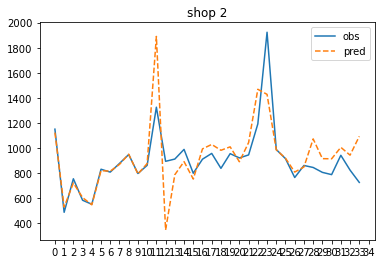

-----------------------shop 3.000000--------------------------
predicted=877.971700, expected=616.000000
Test MSE: 261.972


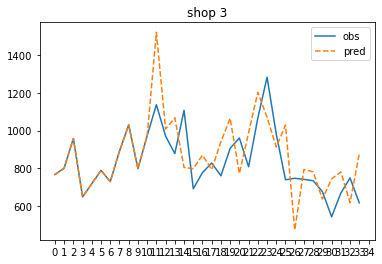

-----------------------shop 4.000000--------------------------
predicted=1139.216604, expected=831.000000
Test MSE: 308.217


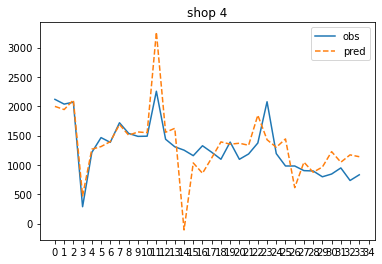

-----------------------shop 5.000000--------------------------
predicted=1536.023381, expected=1054.000000
Test MSE: 482.023


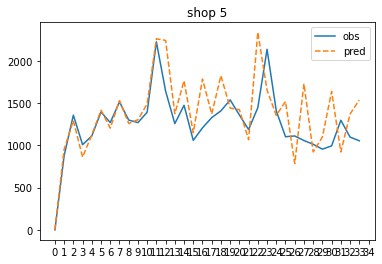

-----------------------shop 6.000000--------------------------
predicted=2169.163114, expected=1803.000000
Test MSE: 366.163


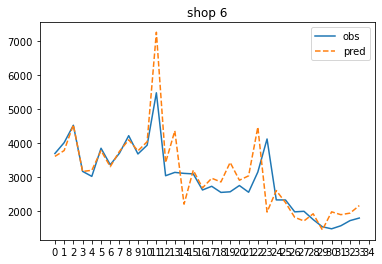

-----------------------shop 7.000000--------------------------
predicted=1647.774343, expected=1216.000000
Test MSE: 431.774


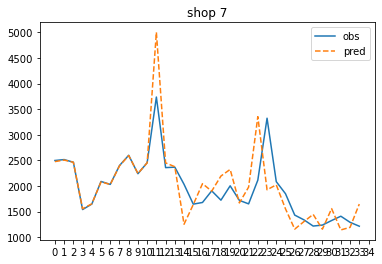

-----------------------shop 8.000000--------------------------
-----------------------shop 9.000000--------------------------
predicted=-5.228211, expected=3188.000000
Test MSE: 3193.228


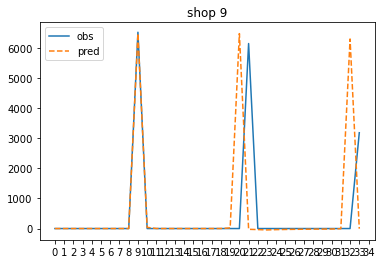

-----------------------shop 10.000000--------------------------
predicted=574.835761, expected=428.000000
Test MSE: 146.836


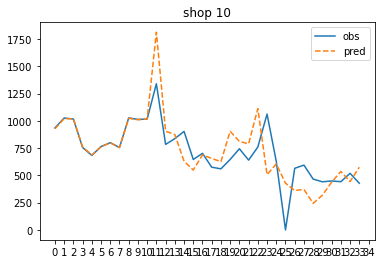

-----------------------shop 11.000000--------------------------
-----------------------shop 12.000000--------------------------
predicted=4445.588157, expected=2016.000000
Test MSE: 2429.588


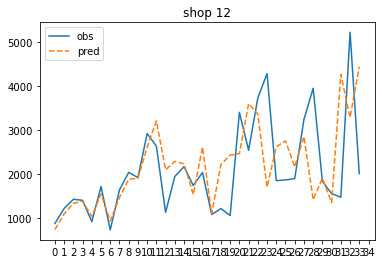

-----------------------shop 13.000000--------------------------
-----------------------shop 14.000000--------------------------
predicted=1261.993437, expected=1007.000000
Test MSE: 254.993


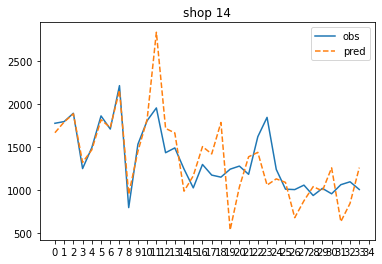

-----------------------shop 15.000000--------------------------
predicted=1641.246806, expected=1248.000000
Test MSE: 393.247


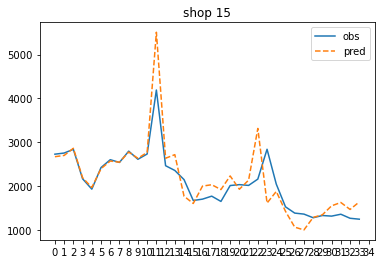

-----------------------shop 16.000000--------------------------
predicted=1622.292430, expected=966.000000
Test MSE: 656.292


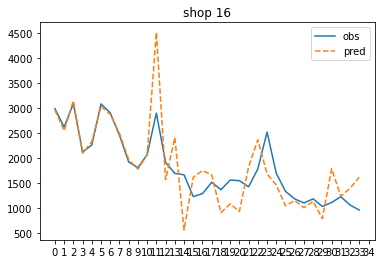

-----------------------shop 17.000000--------------------------
-----------------------shop 18.000000--------------------------
predicted=1293.944448, expected=1212.000000
Test MSE: 81.944


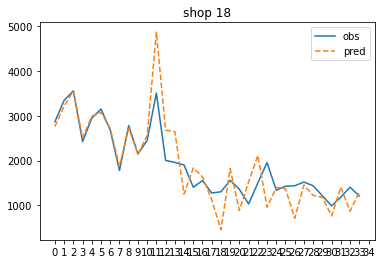

-----------------------shop 19.000000--------------------------
predicted=1576.471723, expected=1453.000000
Test MSE: 123.472


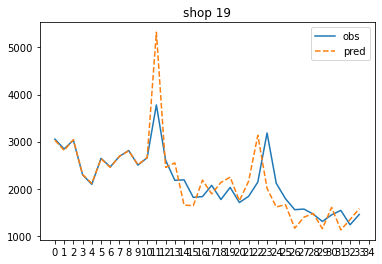

-----------------------shop 20.000000--------------------------
predicted=121.652248, expected=2611.000000
Test MSE: 2489.348


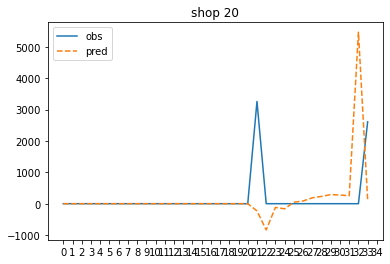

-----------------------shop 21.000000--------------------------
predicted=2311.063632, expected=1913.000000
Test MSE: 398.064


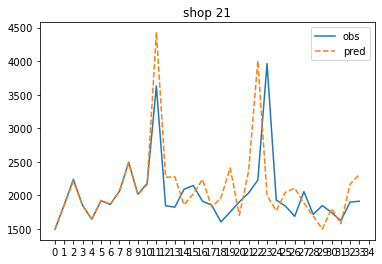

-----------------------shop 22.000000--------------------------
predicted=1445.778471, expected=1338.000000
Test MSE: 107.778


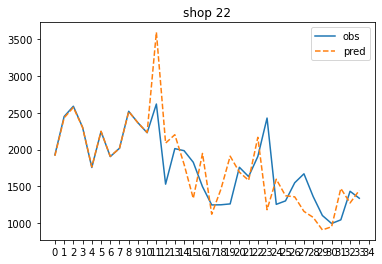

-----------------------shop 23.000000--------------------------
-----------------------shop 24.000000--------------------------
predicted=1443.202330, expected=1228.000000
Test MSE: 215.202


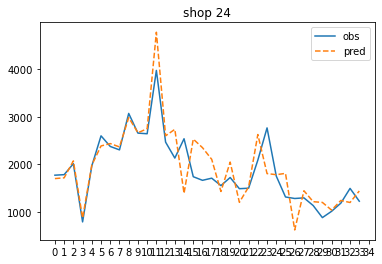

-----------------------shop 25.000000--------------------------
predicted=7043.067585, expected=6261.000000
Test MSE: 782.068


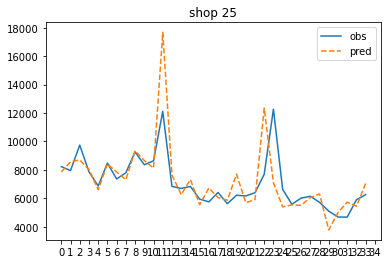

-----------------------shop 26.000000--------------------------
predicted=1396.204974, expected=1412.000000
Test MSE: 15.795


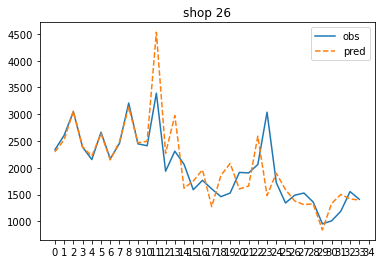

-----------------------shop 27.000000--------------------------
-----------------------shop 28.000000--------------------------
predicted=3582.060934, expected=3021.000000
Test MSE: 561.061


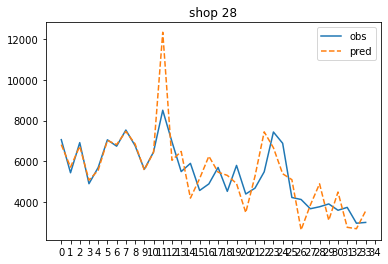

-----------------------shop 29.000000--------------------------
-----------------------shop 30.000000--------------------------
-----------------------shop 31.000000--------------------------
predicted=7829.027944, expected=6119.000000
Test MSE: 1710.028


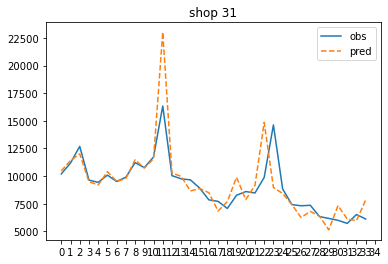

-----------------------shop 32.000000--------------------------
-----------------------shop 33.000000--------------------------
-----------------------shop 34.000000--------------------------
predicted=466.572186, expected=385.000000
Test MSE: 81.572


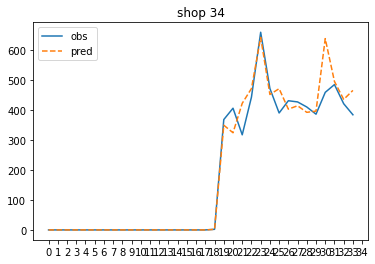

-----------------------shop 35.000000--------------------------
predicted=1946.885335, expected=1421.000000
Test MSE: 525.885


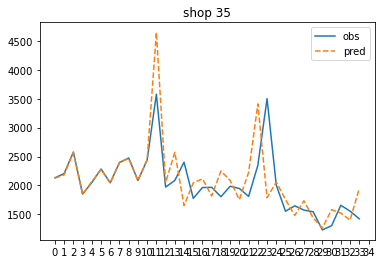

-----------------------shop 36.000000--------------------------
-----------------------shop 37.000000--------------------------
predicted=1600.729327, expected=833.000000
Test MSE: 767.729


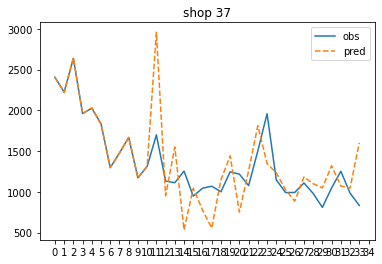

-----------------------shop 38.000000--------------------------
predicted=1537.121080, expected=1114.000000
Test MSE: 423.121


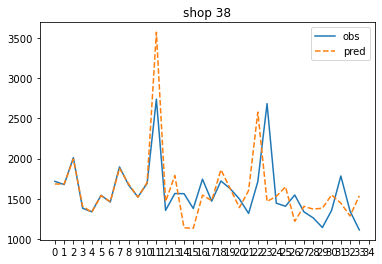

-----------------------shop 39.000000--------------------------
predicted=1067.526885, expected=998.000000
Test MSE: 69.527


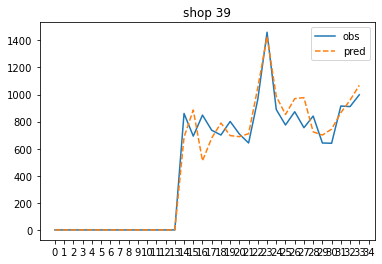

-----------------------shop 40.000000--------------------------
-----------------------shop 41.000000--------------------------
predicted=776.107504, expected=743.000000
Test MSE: 33.108


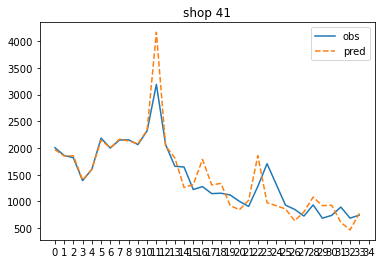

-----------------------shop 42.000000--------------------------
predicted=5105.371940, expected=4498.000000
Test MSE: 607.372


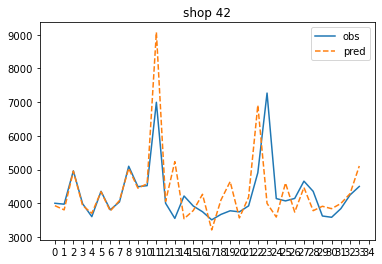

-----------------------shop 43.000000--------------------------
-----------------------shop 44.000000--------------------------
predicted=950.992651, expected=780.000000
Test MSE: 170.993


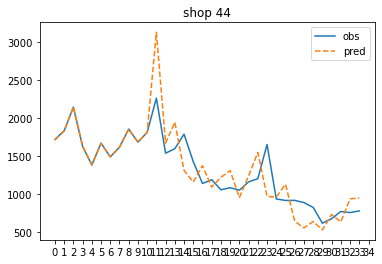

-----------------------shop 45.000000--------------------------
predicted=700.311307, expected=702.000000
Test MSE: 1.689


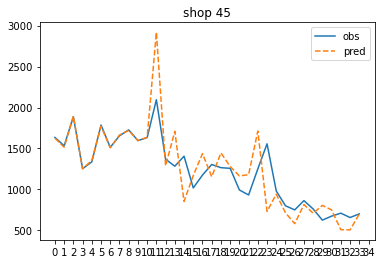

-----------------------shop 46.000000--------------------------
predicted=1633.813524, expected=1322.000000
Test MSE: 311.814


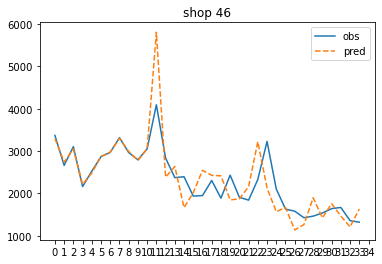

-----------------------shop 47.000000--------------------------
predicted=2437.733514, expected=1785.000000
Test MSE: 652.734


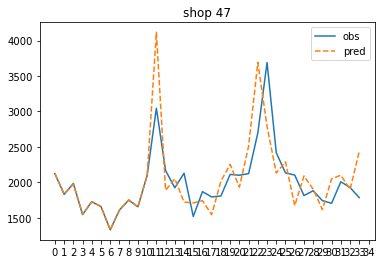

-----------------------shop 48.000000--------------------------
predicted=1257.220692, expected=1119.000000
Test MSE: 138.221


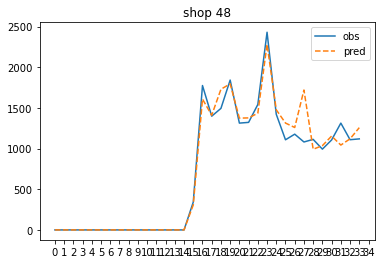

-----------------------shop 49.000000--------------------------
predicted=612.639638, expected=649.000000
Test MSE: 36.360


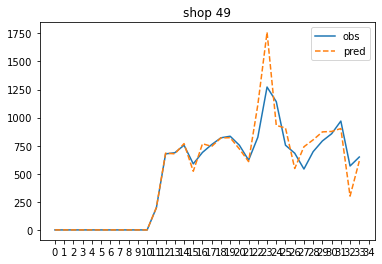

-----------------------shop 50.000000--------------------------
predicted=719.493322, expected=950.000000
Test MSE: 230.507


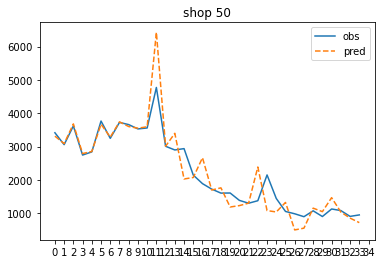

-----------------------shop 51.000000--------------------------
-----------------------shop 52.000000--------------------------
predicted=1039.667031, expected=852.000000
Test MSE: 187.667


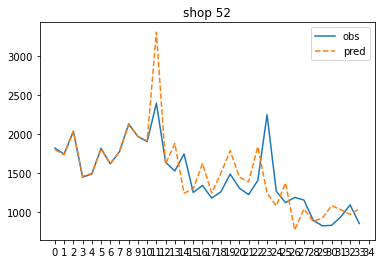

-----------------------shop 53.000000--------------------------
predicted=1342.096379, expected=1065.000000
Test MSE: 277.096


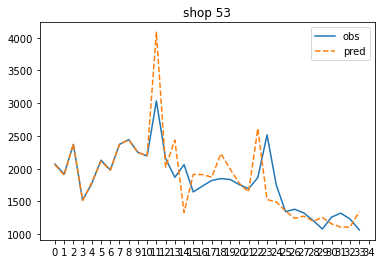

-----------------------shop 54.000000--------------------------
-----------------------shop 55.000000--------------------------
predicted=7078.798094, expected=1972.000000
Test MSE: 5106.798


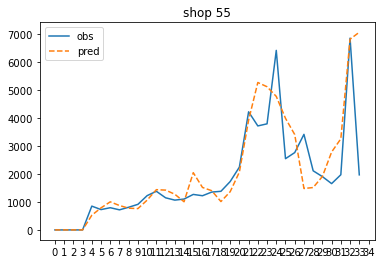

-----------------------shop 56.000000--------------------------
predicted=1077.423782, expected=1267.000000
Test MSE: 189.576


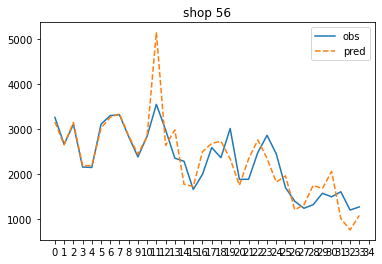

-----------------------shop 57.000000--------------------------
predicted=2024.864873, expected=2319.000000
Test MSE: 294.135


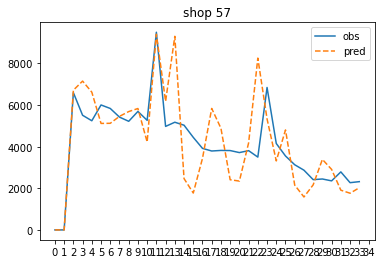

-----------------------shop 58.000000--------------------------
predicted=493.322543, expected=1448.000000
Test MSE: 954.677


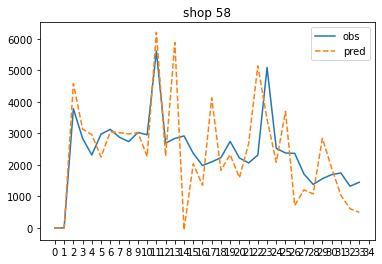

-----------------------shop 59.000000--------------------------
predicted=1386.149541, expected=792.000000
Test MSE: 594.150


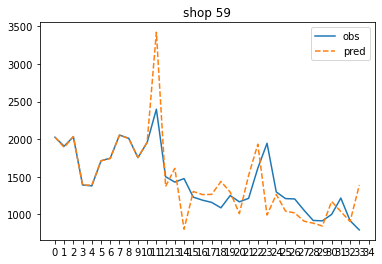

In [61]:
lista_pred_arima=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima.append(train_evaluation_arima(ts_shop,i))

In [62]:
df_pred_arima=middleout_forecasting(lista_pred_arima,3)
df_pred_arima=submission_df(df_pred_arima)
df_pred_arima.rename(columns={'item_cnt_month_y':'pred'},inplace=True)

In [63]:
error_arima = evaluation(df_pred_arima)
print('Test MSE: %.3f' % error_arima)

Test MSE: 1.706


In [64]:
def forecast_arima_shops(ts,i):
    predictions = list()
    train=ts[i].values
    
    if (i in closed_shops or sum(train)==0):
        predictions.append(0)
    else:
        model = SARIMAX(train, order=(0,1,3), seasonal_order=(0,1,1,12))
        model_fit = model.fit()
        output = model_fit.predict(1, len(train)+1, typ='levels')
        yhat = output[-1]
        predictions.append(yhat)

        plt.plot(train,label='obs')
        plt.plot(output, label='pred',ls='--')
        plt.xticks(range(0,len(train)+1))
        plt.legend()
        plt.title('shop '+str(i))
        plt.show()
        
    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

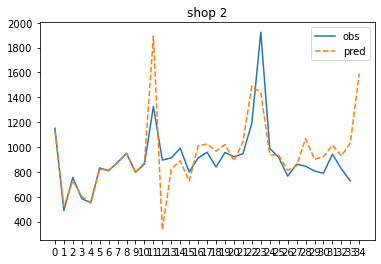

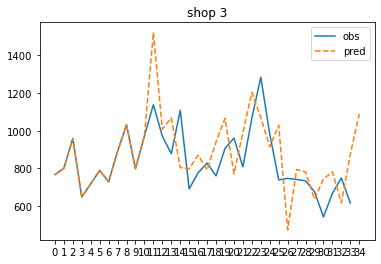

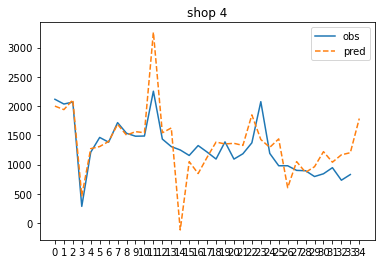

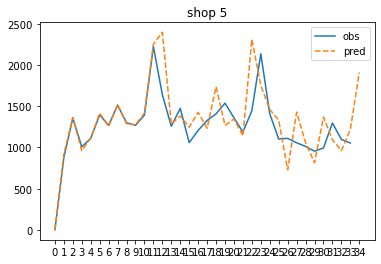

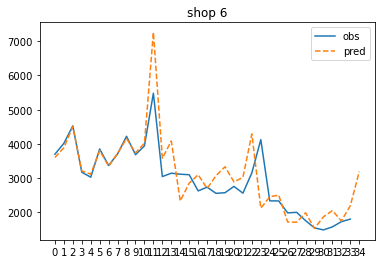

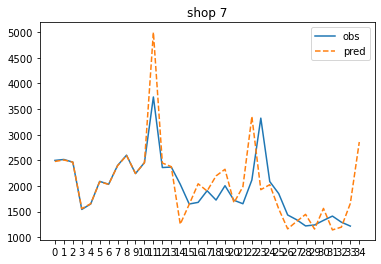

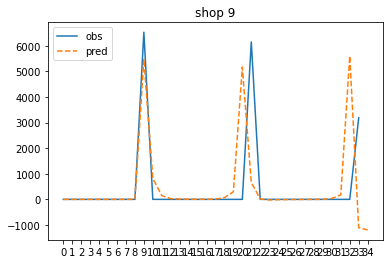

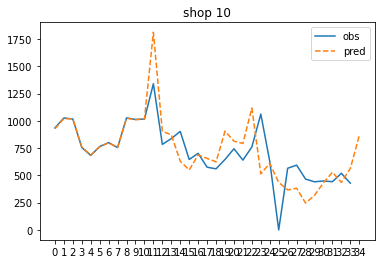

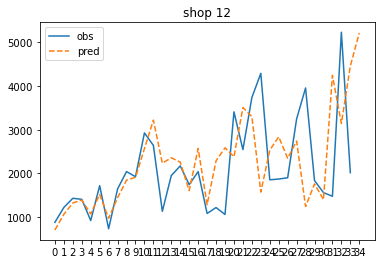

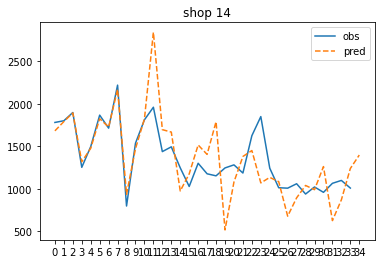

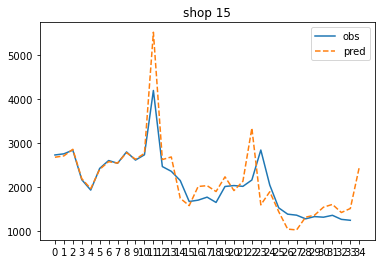

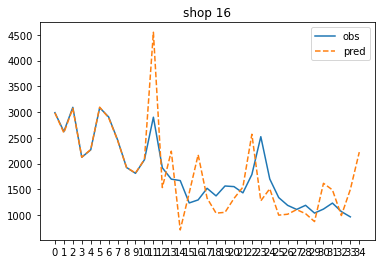

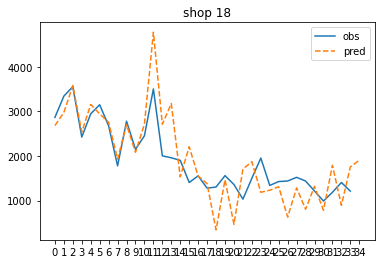

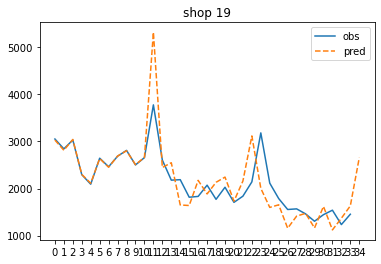

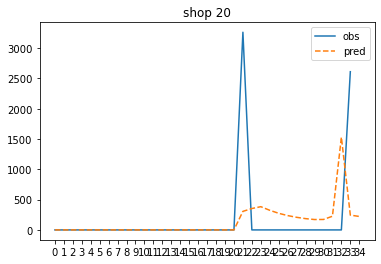

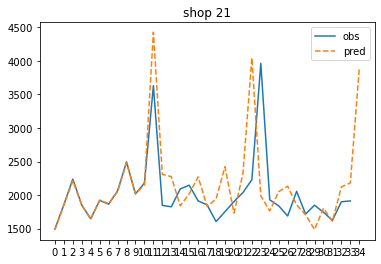

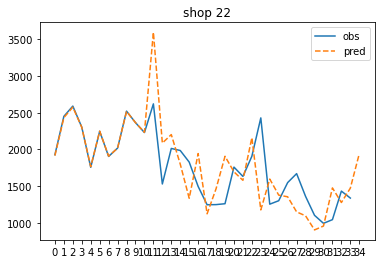

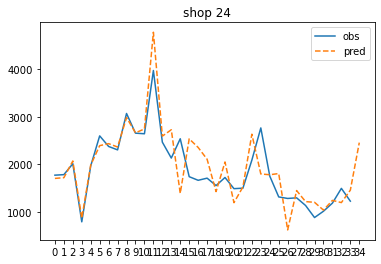

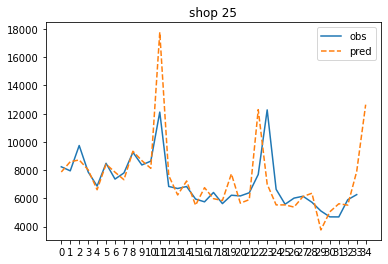

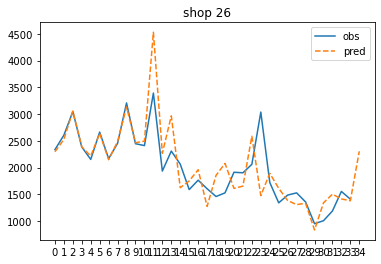

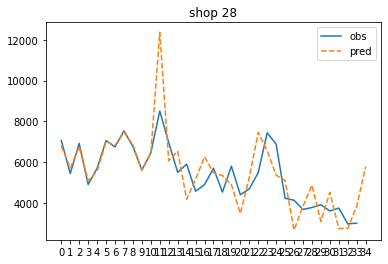

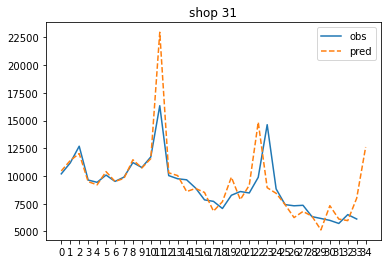

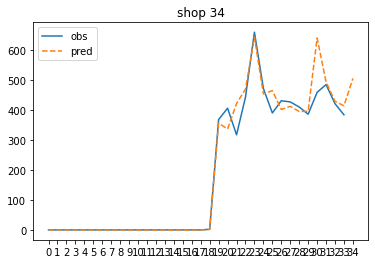

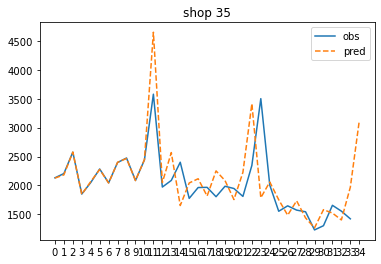

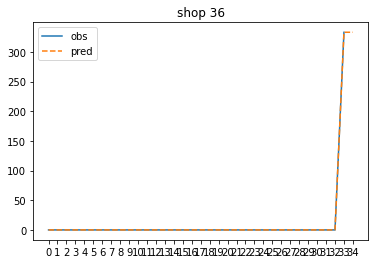

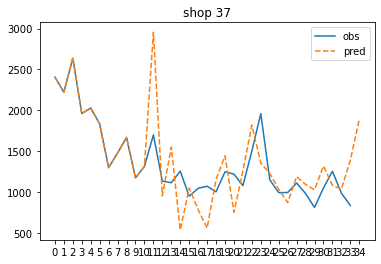

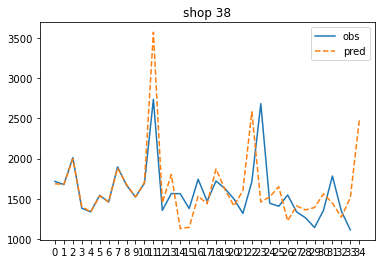

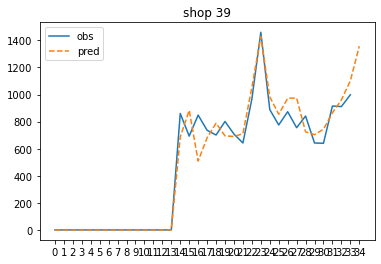

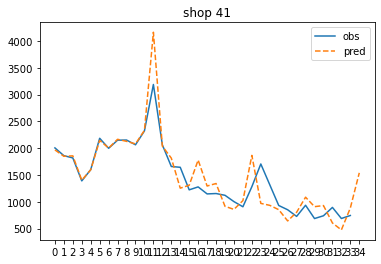

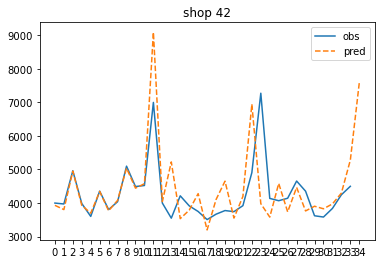

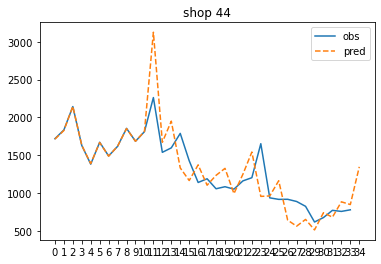

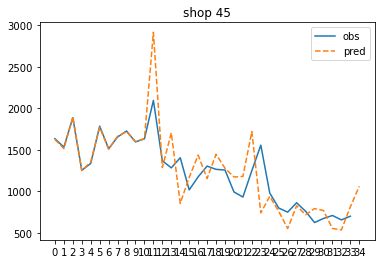

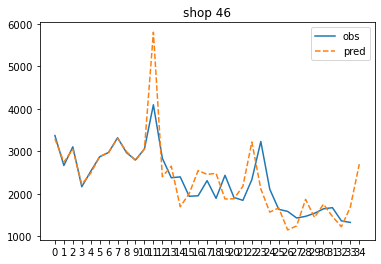

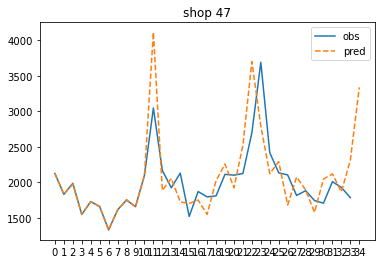

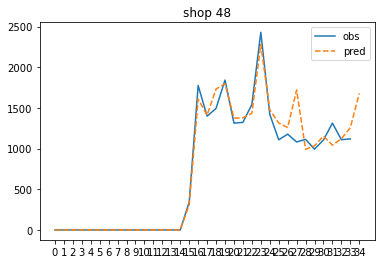

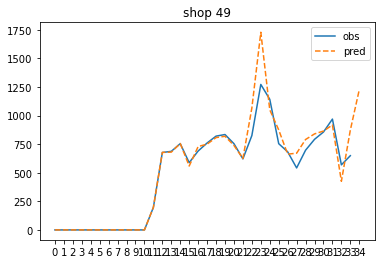

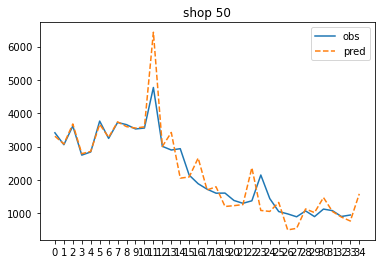

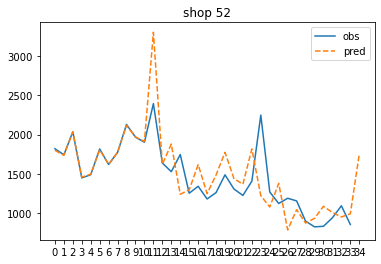

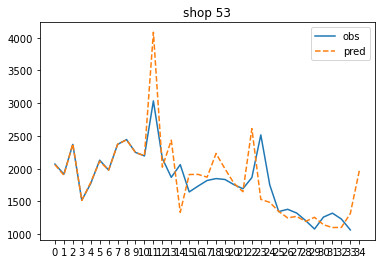

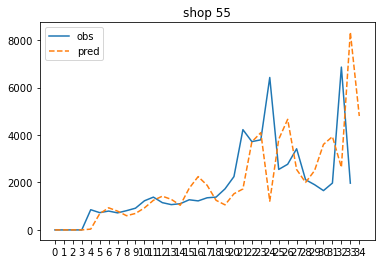

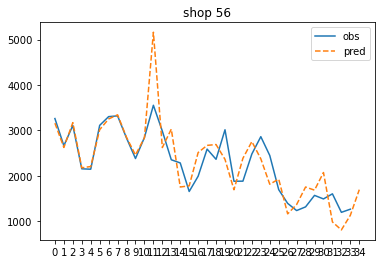

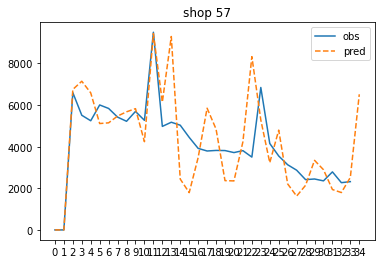

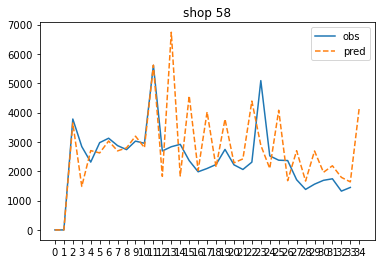

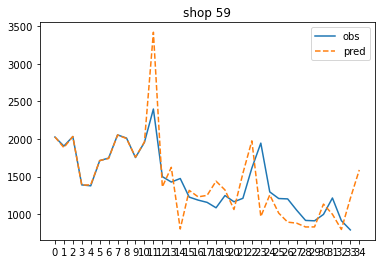

In [65]:
lista_pred_arima_test=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima_test.append(forecast_arima_shops(ts_shop,i))

In [66]:
df_forecast_items=middleout_forecasting(lista_pred_arima_test,3)

In [67]:
# df_final=submission_df(df_forecast_items)
# df_final.to_csv('submission_arima_2.csv', index=False)